In [1]:
import pickle
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.preprocessing import image
import tensorflow as tf
from keras.applications.mobilenet import preprocess_input
from keras.layers import Input, Dropout
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dense
from keras.utils import np_utils
import time

In [2]:
TRAIN_PATH = '/Users/kashyapbastola/Desktop/TARP_PROJ/Pepsico RnD Potato Lab Dataset/Train'
TEST_PATH = '/Users/kashyapbastola/Desktop/TARP_PROJ/Pepsico RnD Potato Lab Dataset/Test'
BATCH_SIZE = 32
COLOR_MODE = 'rgb'
TARGET_SIZE = (255, 255)
GRAY_SCALL = (3,)
INPUT_SIZE = TARGET_SIZE + GRAY_SCALL
EPOCHS = 1
CLASSES = ['Defective','Non-Defective']

In [3]:
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(samplewise_center=True, #making sure that each image has a mean of 0
                                    samplewise_std_normalization=True, #and standard deviation 1
                                    horizontal_flip=True, #Randomly flip inputs horizontally
                                    validation_split=0.3,
                                    )

In [4]:
train_data = data_generator.flow_from_directory(directory=TRAIN_PATH,target_size=TARGET_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',color_mode=COLOR_MODE,subset='training',shuffle=True)         
    
validation_data = data_generator.flow_from_directory(directory=TRAIN_PATH,target_size=TARGET_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',color_mode=COLOR_MODE,subset='validation',shuffle=True)             

test_data = data_generator.flow_from_directory(directory=TEST_PATH,target_size=TARGET_SIZE,batch_size=BATCH_SIZE,class_mode='categorical',color_mode=COLOR_MODE,shuffle=True)

Found 539 images belonging to 2 classes.
Found 230 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

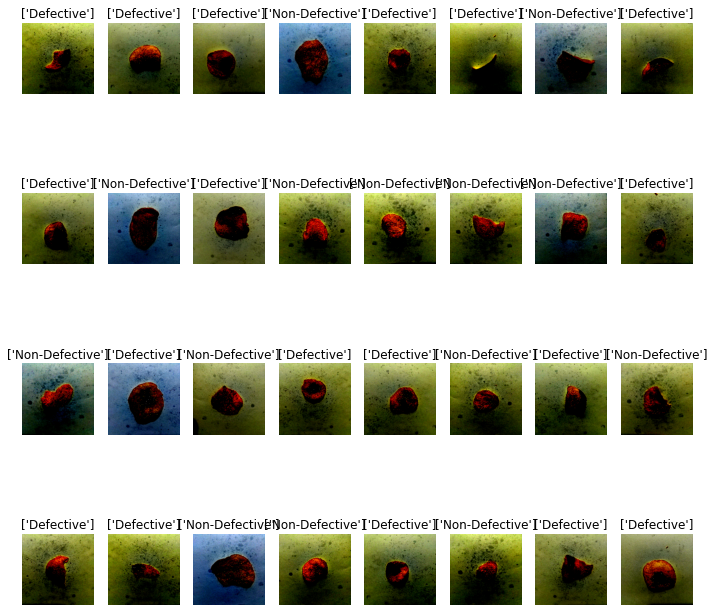

In [5]:
import matplotlib.pyplot as plt
images, labels = train_data.next()
classes = np.asarray(CLASSES)

_, axs = plt.subplots(4, 8, figsize=(12,12))
axs = axs.flatten()
for img, label, ax in zip(images, labels, axs):
    ax.imshow(img)
    ax.axis('off')
    label = label.astype(int)
    ax.set_title(classes[label == 1])
plt.show()

In [6]:
def my_model():
  MobileNet_model = MobileNet(weights='imagenet',include_top=False,input_shape=INPUT_SIZE)
  MobileNet_model.trainable = False
  flatten =Flatten()(MobileNet_model.layers[-1].output)
  fc1 = Dense(units=4096, activation ='relu')(flatten)
  dropout = Dropout(0.2)(fc1)
  fc2 = Dense(units=1024,activation='relu')(dropout)
  output = Dense(2, activation='softmax')(fc2)
  model = Model(inputs = MobileNet_model.input, outputs=output)
  model.summary()
  return model

In [7]:
model = my_model()

2022-08-25 10:28:44.218306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 128, 128, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 128, 128, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 16, 16, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 16, 16, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 16, 16, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 16, 16, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 16, 16, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 16, 16, 512)       262144    
                                                                 
 conv_pw_9

In [8]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='T', expand_nested=False, dpi=96
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss = tf.keras.losses.CategoricalCrossentropy()

In [10]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [11]:
from tensorflow.keras.layers import  Flatten, Dense, Dropout
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='my_modelMOBILENET.h5', 
                                                    monitor='accuracy', verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False, 
                                                    mode='auto', 
                                                    save_freq='epoch')
earlystoping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', 
                                                    min_delta=0, 
                                                    patience=5,  #Number of epochs with no improvement after which training will be stopped.
                                                    verbose=1, 
                                                    mode='auto')
import datetime
log_dir = './logs/fit/' + datetime.datetime.now().strftime('%m.%d.%Y--%H-%M-%S')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                 histogram_freq=1, 
                                                 write_graph=True,
                                                 write_images=False, 
                                                 update_freq='epoch')

In [ ]:
history = model.fit(x=train_data, 
                        epochs=EPOCHS, 
                        steps_per_epoch=len(train_data), 
                        verbose=1, 
                        validation_data=validation_data, 
                        validation_steps=1, 
                        callbacks=[checkpoint, earlystoping, tensorboard])
    
# -- Save model -- 
model.save('my_modelMOBILENET.h5')

17/17 [==============================] - ETA: 0s - loss: 38.0239 - accuracy: 0.6939
Epoch 1: accuracy improved from -inf to 0.69388, saving model to my_modelMOBILENET.h5
